## Rent burden figures for ARB report

Sam Maurer, updated October 2016 (based on "Rent burden diagnostics" in the parent directory)

In [1]:
%load_ext autoreload
%aimport baus
%autoreload 1
%matplotlib inline

In [21]:
from baus import models
from baus import ual
import orca

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

In [3]:
# To load the config files, urbansim.utils.misc expects to be running from the
# root of an urbansim instance
import os
os.chdir("/Users/smmaurer/Dropbox/Git-rMBP/ual/bayarea_urbansim")

### Execute model steps to generate fitted rents

In [4]:
orca.run([
    # initialization
    "ual_initialize_residential_units",
    "ual_match_households_to_units",
    "ual_assign_tenure_to_units",
    "ual_load_rental_listings",
    # simulation
    "neighborhood_vars",
    "regional_vars",
    "ual_rsh_simulate",
    "ual_rrh_simulate",    
])

Running step 'ual_initialize_residential_units'
Filling column shape_area with value 602.839834979 (0 values)
Filling column zone_id with value 1178 (0 values)
Filling column building_type_id with value 1 (0 values)
Filling column residential_units with value 0 (0 values)
Filling column year_built with value 1967.0 (0 values)
Filling column non_residential_sqft with value 0 (0 values)
Total deed restricted units after random selection: 116407
Total deed restricted units after truncating to res units: 113116
Time to execute step 'ual_initialize_residential_units': 50.10 s
Running step 'ual_match_households_to_units'
Time to execute step 'ual_match_households_to_units': 85.57 s
Running step 'ual_assign_tenure_to_units'
Initial unit tenure assignment: 58% owner occupied, 6% unfilled
Time to execute step 'ual_assign_tenure_to_units': 24.32 s
Running step 'neighborhood_vars'
Computing accessibility variables
Computing retail_sqft_3000
Computing sum_income_3000
Removed 4409 rows because they

/Users/smmaurer/anaconda/lib/python2.7/site-packages/pandas/computation/expressions.py:181: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  unsupported[op_str]))


### Rent burden diagnostics

`rent_burden` is a column that's added to the `households` table (in `variables.py`), calculated by dividing fitted yearly rent by PUMS household income. If either component is missing, rent burden is set to zero. 

Rent burden is computed even if a household is not renting, so when you're using it, restrict the population to rental households if necessary.

Note that `unit_residential_rent` is a price per square foot, so the rent burden calculation also requires the `sqft_per_unit` column from the `buildings` table.

### Fitted rent per square foot

(This looks different from the earlier version because it's derived from the MTC regression specifications instead of the UAL specifications. Can be changed as needed.)

In [5]:
u = orca.get_table("residential_units")
u = u.to_frame()

In [6]:
u.unit_residential_rent.describe()

count    2.785868e+06
mean     2.242878e+00
std      7.218066e-01
min      8.333333e-01
25%      1.761685e+00
50%      2.268455e+00
75%      2.714222e+00
max      4.543146e+00
Name: unit_residential_rent, dtype: float64

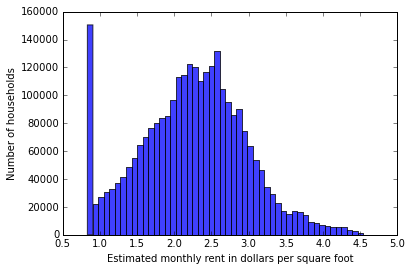

In [75]:
fig = plt.figure()
plt.hist(u.unit_residential_rent, bins=50, alpha=0.75)
plt.xlabel('Estimated monthly rent in dollars per square foot')
plt.ylabel('Number of households')
# fig.savefig('test.pdf')

In [8]:
u.unit_residential_rent.isnull().sum()

0

### Rent per square foot, from Craigslist data

In [44]:
c = orca.get_table("craigslist")
c = c.to_frame()

In [65]:
c.price_per_sqft.describe()

count    73644.000000
mean         4.697802
std        183.768413
min          0.000154
25%          2.055256
50%          2.587519
75%          3.135714
max      31145.389277
Name: price_per_sqft, dtype: float64

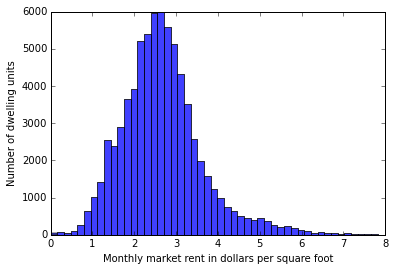

In [90]:
fig = plt.figure()
plt.hist(c.price_per_sqft[c.price_per_sqft<8], bins=50, alpha=0.75)
plt.xlabel('Monthly market rent in dollars per square foot')
plt.ylabel('Number of dwelling units')
fig.savefig('Fig 3-5 rent per square foot.pdf')

### Size of dwelling units, from the MTC building data

In [9]:
b = orca.get_table("buildings")
b = b.to_frame()

In [36]:
b.sqft_per_unit.describe()

count    1.843351e+06
mean     1.857760e+03
std      1.080698e+03
min      4.000000e+02
25%      1.200000e+03
50%      1.636000e+03
75%      2.124000e+03
max      6.000000e+03
Name: sqft_per_unit, dtype: float64

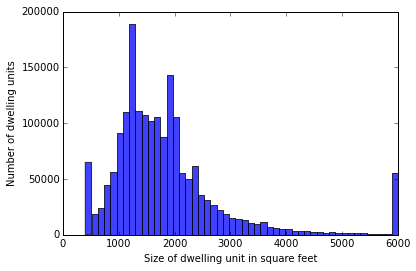

In [77]:
fig = plt.figure()
plt.hist(b.sqft_per_unit.values, bins=50, alpha=0.75)
plt.xlabel('Size of dwelling unit in square feet')
plt.ylabel('Number of dwelling units')
# fig.savefig('test.pdf')

In [26]:
b.sqft_per_unit.isnull().sum()

0

### Size of dwelling units, from the Craiglist data

In [47]:
c.sqft_per_unit.describe()

count    7.364400e+04
mean     1.196621e+03
std      3.119264e+04
min      1.000000e+00
25%      7.200000e+02
50%      9.040000e+02
75%      1.160000e+03
max      8.388607e+06
Name: sqft_per_unit, dtype: float64

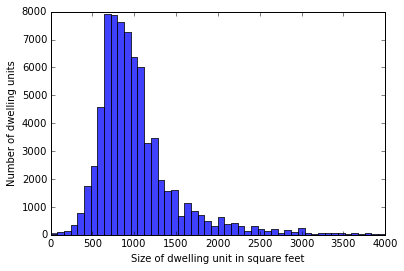

In [78]:
fig = plt.figure()
plt.hist(c.sqft_per_unit[c.sqft_per_unit < 4000].values, bins=50, alpha=0.75)
plt.xlabel('Size of dwelling unit in square feet')
plt.ylabel('Number of dwelling units')
fig.savefig('Fig 3-6 size of dwelling units.pdf')

### Household income, from PUMS-based synthetic population

In [14]:
h = orca.get_table("households")
h = h.to_frame()

In [15]:
# Household income
h.income.describe()

count    2.608019e+06
mean     8.138398e+04
std      8.149481e+04
min     -2.000000e+04
25%      3.020000e+04
50%      6.090000e+04
75%      1.020000e+05
max      1.968504e+06
Name: income, dtype: float64

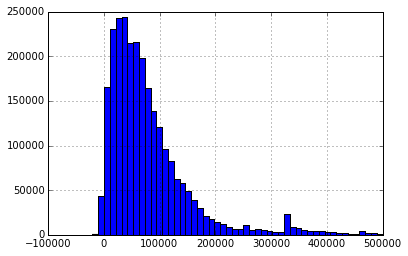

In [16]:
h.income[h.income < 500000].hist(bins=50)
# households with negative income are set to zero rent burden

### Rent burden, from fitted rents and PUMS-based synthetic incomes

In [83]:
# Not currently defined in the households table, so bringing back earlier defs

from urbansim.utils import misc

@orca.column('households', 'positive_income')
def positive_income(households):
    inc = households.income
    inc[inc < 1] = 1
    return inc.fillna(1)

@orca.column('households', 'hh_monthly_rent')
def hh_monthly_rent(households, buildings, residential_units):
    rent = misc.reindex(residential_units.unit_residential_rent, households.unit_id)
    sqft = misc.reindex(buildings.sqft_per_unit, households.unit_id)
    return rent.multiply(sqft).fillna(0)

@orca.column('households', 'rent_burden')
def rent_burden(households):
    rb = households.hh_monthly_rent.multiply(12).divide(households.positive_income)
    return rb.replace([np.inf, -np.inf], np.nan).fillna(0)

In [84]:
h = orca.get_table("households")
h = h.to_frame()

In [85]:
# Rent burden
h.rent_burden.describe()

count    2.608019e+06
mean     5.154600e+02
std      6.411310e+03
min      0.000000e+00
25%      0.000000e+00
50%      3.381574e-01
75%      1.041760e+00
max      3.268160e+05
Name: rent_burden, dtype: float64

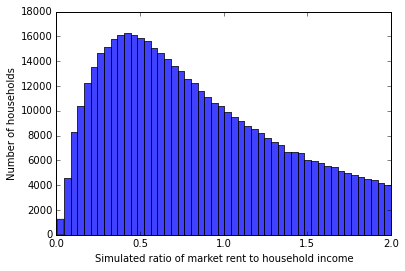

In [91]:
trimmed_burden = h.rent_burden[(h.hownrent == 2) & (h.rent_burden > 0) & (h.rent_burden < 2)]

fig = plt.figure()
plt.hist(trimmed_burden.values, bins=50, alpha=0.75)
plt.xlabel('Simulated ratio of market rent to household income')
plt.ylabel('Number of households')
fig.savefig('Fig 3-7 rent burden.pdf')